In [ ]:
!pip install mysqlclient

In [ ]:
!sudo apt-get install python3-dev libmysqlclient-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libmysqlclient-dev is already the newest version (8.0.35-0ubuntu0.22.04.1).
python3-dev is already the newest version (3.10.6-1~22.04).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.


In [ ]:
try:
    import configparser
except:
    from six.moves import configparser

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import configparser

In [ ]:
import math
import numpy as np
import warnings

class Aggregators:
    def __init__(self):
        pass

    #pass ratings or factors as input
    @staticmethod
    def average(arr):
        return np.average(arr, axis = 0, weights = None)

    @staticmethod
    def average_bf(arr):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            arr[arr == 0] = np.nan
            return np.nanmean(arr, axis=0)

    @staticmethod
    def weighted_average(arr, weights):
        return np.average(arr, axis = 0, weights = weights)

In [ ]:


class Group:
    def __init__(self, members, candidate_items, ratings):
        # member ids
        self.members = sorted(members)

        # List of items that can be recommended.
        # These should not have been watched by any member of group.
        self.candidate_items = candidate_items

        self.actual_recos = []
        self.false_positive = []

        self.ratings_per_member = [np.size(ratings[member].nonzero()) for member in self.members]

        # AF
        self.grp_factors_af = []
        self.bias_af = 0
        self.precision_af = 0
        self.recall_af = 0
        self.reco_list_af = []

        # BF
        self.grp_factors_bf = []
        self.bias_bf = 0
        self.precision_bf = 0
        self.recall_bf = 0
        self.reco_list_bf = []

        # WBF
        self.grp_factors_wbf = []
        self.bias_wbf = 0
        self.precision_wbf = 0
        self.recall_wbf = 0
        self.weight_matrix_wbf = []
        self.reco_list_wbf = []

#Configuration reader.
class Config:
    def __init__(self, config_file_path):
        self.config_file_path = config_file_path
        # print("config_file_path  : ",config_file_path);
        configParser = configparser.RawConfigParser()
        configParser.read(config_file_path)

        #movie lens 100k dataset, 80 - 20 train/test ratio, present in data directory
        self.training_file = configParser.get('Config', 'training_file')
        self.testing_file = configParser.get('Config', 'testing_file')

        self.small_grp_size = int(configParser.get('Config', 'small_grp_size'))
        self.medium_grp_size = int(configParser.get('Config', 'medium_grp_size'))
        self.large_grp_size = int(configParser.get('Config', 'large_grp_size'))

        self.max_iterations_mf = int(configParser.get('Config', 'max_iterations_mf'))
        self.lambda_mf = float(configParser.get('Config', 'lambda_mf'))
        self.learning_rate_mf = float(configParser.get('Config', 'learning_rate_mf'))

        self.num_factors = int(configParser.get('Config', 'num_factors'))

        #AF (after factorization)
        self.rating_threshold_af = float(configParser.get('Config', 'rating_threshold_af'))
        self.num_recos_af = int(configParser.get('Config', 'num_recos_af'))

        #BF (before factorization)
        self.rating_threshold_bf = float(configParser.get('Config', 'rating_threshold_bf'))
        self.num_recos_bf = int(configParser.get('Config', 'num_recos_bf'))

        #WBF (weighted before factorization)
        self.rating_threshold_wbf = float(configParser.get('Config', 'rating_threshold_wbf'))
        self.num_recos_wbf = int(configParser.get('Config', 'num_recos_wbf'))

        self.is_debug = configParser.getboolean('Config', 'is_debug')

In [ ]:
@staticmethod
def find_candidate_items(ratings, members):
    if len(members) == 0: return []

    unwatched_items = np.argwhere(ratings[members[0]] == 0)
    for member in members:
        cur_unwatched = np.argwhere(ratings[member] == 0)
        unwatched_items = np.intersect1d(unwatched_items, cur_unwatched)
    # print("unwatched_items : ", unwatched_items);
    return unwatched_items
Group.find_candidate_items = find_candidate_items

In [ ]:
@staticmethod
def non_testable_items(members, ratings):
    non_eval_items = np.argwhere(ratings[members[0]] == 0)
    for member in members:
        cur_non_eval_items = np.argwhere(ratings[member] == 0)
        non_eval_items = np.intersect1d(non_eval_items, cur_non_eval_items)
    # print("non_eval_items : ",non_eval_items);
    return non_eval_items
Group.non_testable_items = non_testable_items

In [ ]:
@staticmethod
def generate_groups(cfg, ratings, test_ratings, num_users, count, size, disjoint = True):
    avbl_users = [i for i in range(num_users)]
    groups = []
    testable_threshold = 50

    iter_idx = 0
    while iter_idx in range(count):
        group_members = np.random.choice(avbl_users, size = size, replace = False)
        candidate_items = Group.find_candidate_items(ratings, group_members)
        non_eval_items = Group.non_testable_items(group_members, test_ratings)
        testable_items = np.setdiff1d(candidate_items, non_eval_items)
        # print("candidate_items : ",candidate_items);
        # print("non_eval_items : ",non_eval_items);
        # print("testable_items : ",testable_items);

        if len(candidate_items) != 0 and len(testable_items) >= testable_threshold:
            groups += [Group(group_members, candidate_items, ratings)]
            avbl_users = np.setdiff1d(avbl_users, group_members)
            iter_idx += 1

    # print("groups : ",groups);
    return groups

Group.generate_groups = generate_groups

In [ ]:
def generate_actual_recommendations(self, ratings, threshold):
    non_eval_items = Group.non_testable_items(self.members, ratings)

    items = np.argwhere(np.logical_or(ratings[self.members[0]] >= threshold, ratings[self.members[0]] == 0)).flatten()
    fp = np.argwhere(np.logical_and(ratings[self.members[0]] > 0, ratings[self.members[0]] < threshold)).flatten()
    for member in self.members:
        cur_items = np.argwhere(np.logical_or(ratings[member] >= threshold, ratings[member] == 0)).flatten()
        fp = np.union1d(fp, np.argwhere(np.logical_and(ratings[member] > 0, ratings[member] < threshold)).flatten())
        items = np.intersect1d(items, cur_items)

    items = np.setdiff1d(items, non_eval_items)


    self.actual_recos = items
    self.false_positive = fp

Group.generate_actual_recommendations  = generate_actual_recommendations


In [ ]:
def evaluate_af(self, is_debug=False):
    tp = float(np.intersect1d(self.actual_recos, self.reco_list_af).size)
    fp = float(np.intersect1d(self.false_positive, self.reco_list_af).size)

    try:
        self.precision_af = tp / (tp + fp)
    except ZeroDivisionError:
        self.precision_af = np.NaN

    try:
        self.recall_af = tp / self.actual_recos.size
    except ZeroDivisionError:
        self.recall_af = np.NaN

    if is_debug:
        print ('tp: ', tp)
        print ('fp: ', fp)
        print ('precision_af: ', self.precision_af)
        print ('recall_af: ', self.recall_af)

    return self.precision_af, self.recall_af, tp, fp
Group.evaluate_af = evaluate_af

In [ ]:
def evaluate_bf(self, is_debug=False):
    tp = float(np.intersect1d(self.actual_recos, self.reco_list_bf).size)
    fp = float(np.intersect1d(self.false_positive, self.reco_list_bf).size)

    try:
        self.precision_bf = tp / (tp + fp)
    except ZeroDivisionError:
        self.precision_bf = np.NaN

    try:
        self.recall_bf = tp / self.actual_recos.size
    except ZeroDivisionError:
        self.recall_bf = np.NaN

    if is_debug:
        print ('tp: ', tp)
        print ('fp: ', fp)
        print ('precision_bf: ', self.precision_bf)
        print ('recall_bf: ', self.recall_bf)

    return self.precision_bf, self.recall_bf, tp, fp
Group.evaluate_bf = evaluate_bf

In [ ]:
def evaluate_wbf(self, is_debug=False):
    tp = float(np.intersect1d(self.actual_recos, self.reco_list_wbf).size)
    fp = float(np.intersect1d(self.false_positive, self.reco_list_wbf).size)

    try:
        self.precision_wbf = tp / (tp + fp)
    except ZeroDivisionError:
        self.precision_wbf = np.NaN

    try:
        self.recall_wbf = tp / self.actual_recos.size
    except ZeroDivisionError:
        self.recall_wbf = np.NaN

    if is_debug:
        print ('tp: ', tp)
        print ('fp: ', fp)
        print ('precision_bf: ', self.precision_wbf)
        print ('recall_bf: ', self.recall_wbf)
    return self.precision_wbf, self.recall_wbf, tp, fp
Group.evaluate_wbf = evaluate_wbf

In [ ]:
from sklearn.metrics import mean_squared_error

import numpy as np
import pandas as ps


# overflow warnings should be raised as errors
np.seterr(over='raise')

class GroupRec:
    def __init__(self):
        self.cfg = Config("/content/config.conf")
        # print("hello");
        # training and testing matrices
        self.ratings = None
        self.test_ratings = None

        self.groups = []

        # read data into above matrices
        self.read_data()

        self.num_users = self.ratings.shape[0]
        self.num_items = self.ratings.shape[1]

        # print("num_user : ",self.num_users);
        # print("num_items : ",self.num_items);

        # predicted ratings matrix based on factors.
        self.predictions = np.zeros((self.num_users, self.num_items))

        # print("self.predication : ",self.predictions );

        # output after svd factorization
        # initialize all unknowns with random values from -1 to 1

        self.user_factors = np.random.uniform(-1, 1, (self.ratings.shape[0], self.cfg.num_factors))
        self.item_factors = np.random.uniform(-1, 1, (self.ratings.shape[1], self.cfg.num_factors))

        # print("user_factors : ", self.user_factors);
        # print("item_factors : ", self.item_factors);

        self.user_biases = np.zeros(self.num_users)
        self.item_biases = np.zeros(self.num_items)

        # print("user_biases : ",self.user_biases);
        # print("item_biases : ",self.item_biases);

        # global mean of ratings a.k.a mu
        self.ratings_global_mean = 0

    # add list of groups
    def add_groups(self, groups):
        self.groups = groups
        # print("groups : ",self.groups);

    # remove groups
    def remove_groups(self, groups):
        self.groups = []

In [ ]:
# read training and testing data into matrices
def read_data(self):
    column_headers = ['user_id', 'item_id', 'rating', 'timestamp']

    print( 'Reading training data from ', self.cfg.training_file, '...')
    training_data = ps.read_csv("/content/u1.base", sep='\t', names=column_headers)

    # print("training_data ",training_data)

    print ('Reading testing data from ', self.cfg.testing_file, '...')
    testing_data = ps.read_csv("/content/u1.test", sep='\t', names=column_headers)

    # print("testing_data ",testing_data)

    num_users = max(training_data.user_id.unique())
    num_items = max(training_data.item_id.unique())



    # print("num_users : ",num_users , "num_items : ",num_items);

    self.ratings = np.zeros((num_users, num_items))
    self.test_ratings = np.zeros((num_users, num_items))

    # print("ratings ", self.ratings);
    # print("test_ratings : ",self.test_ratings);

    for row in training_data.itertuples(index=False):
        self.ratings[row.user_id - 1, row.item_id - 1] = row.rating

    for row in testing_data.itertuples(index=False):
        self.test_ratings[row.user_id - 1, row.item_id - 1] = row.rating

    # print("ratings ", self.ratings);
    # print("test_ratings : ",self.test_ratings);

GroupRec.read_data = read_data

In [ ]:
def sgd_factorize(self):
    #solve for these for matrix ratings
    ratings_row, ratings_col = self.ratings.nonzero()
    # print("rating : ",self.ratings);
    # print("rating_row : ",ratings_row ,"rating_col : ",ratings_col);
    num_ratings = len(ratings_row)
    # yeh kiya learning_rate - shayad loss function se related hai
    learning_rate = self.cfg.learning_rate_mf
    regularization = self.cfg.lambda_mf

    self.ratings_global_mean = np.mean(self.ratings[np.where(self.ratings != 0)])
    print('rating_global_mean : ', self.ratings_global_mean);
    # print( "learning_rate : ",learning_rate,"\n regular : ",regularization);
    # print("rating : ", self.ratings);
    print ('Doing matrix factorization...')

    # shayad  user_factor_&_item_factor & user_&_item_biases
    try:
        for iter in range(self.cfg.max_iterations_mf):
            print ('Iteration: ', iter)
            rating_indices = np.arange(num_ratings)
            np.random.shuffle(rating_indices)
            print("rating_indices : ",rating_indices);

            for idx in rating_indices:
                user = ratings_row[idx]
                item = ratings_col[idx]

                pred = self.predict_user_rating(user, item)
                error = self.ratings[user][item] - pred

                self.user_factors[user] += learning_rate \
                                            * ((error * self.item_factors[item]) - (regularization * self.user_factors[user]))
                self.item_factors[item] += learning_rate \
                                            * ((error * self.user_factors[user]) - (regularization * self.item_factors[item]))

                self.user_biases[user] += learning_rate * (error - regularization * self.user_biases[user])
                self.item_biases[item] += learning_rate * (error - regularization * self.item_biases[item])

            self.sgd_mse()

    except FloatingPointError:
        print ('Floating point Error: ')
GroupRec.sgd_factorize = sgd_factorize


def sgd_mse(self):
    # predicate  & call predicat_all_ratings()
    self.predict_all_ratings()
    predicted_training_ratings = self.predictions[self.ratings.nonzero()].flatten()
    actual_training_ratings = self.ratings[self.ratings.nonzero()].flatten()

    predicted_test_ratings = self.predictions[self.test_ratings.nonzero()].flatten()
    actual_test_ratings = self.test_ratings[self.test_ratings.nonzero()].flatten()

    training_mse = mean_squared_error(predicted_training_ratings, actual_training_ratings)
    print ('training mse: ', training_mse)
    test_mse = mean_squared_error(predicted_test_ratings, actual_test_ratings)
    print ('test mse: ', test_mse)
GroupRec.sgd_mse = sgd_mse


def predict_user_rating(self, user, item):
    prediction = self.ratings_global_mean + self.user_biases[user] + self.item_biases[item]
    prediction += self.user_factors[user, :].dot(self.item_factors[item, :].T)
    return prediction
GroupRec.predict_user_rating = predict_user_rating

def predict_group_rating(self, group, item, method):
    if (method == 'af'):
        factors = group.grp_factors_af; bias_group = group.bias_af
    elif (method == 'bf'):
        factors = group.grp_factors_bf; bias_group = group.bias_bf
    elif (method == 'wbf'):
        factors = group.grp_factors_wbf; bias_group = group.bias_wbf

    return self.ratings_global_mean + bias_group + self.item_biases[item] \
                                    + np.dot(factors.T, self.item_factors[item])
GroupRec.predict_group_rating = predict_group_rating

def predict_all_ratings(self):
    for user in range(self.num_users):
        for item in range(self.num_items):
            self.predictions[user, item] = self.predict_user_rating(user, item)
GroupRec.predict_all_ratings = predict_all_ratings


In [ ]:
#AF method
def af_runner(self, groups = None, aggregator = Aggregators.average):
    #if groups is not passed, use self.groups
    if (groups is None):
        groups = self.groups

    #calculate factors
    for group in groups:
        member_factors = self.user_factors[group.members, :]
        member_biases = self.user_biases[group.members]

        # print("member_factors ",member_factors);
        # print("member_biases ",member_biases);

        #aggregate the factors
        if (aggregator == Aggregators.average):
            group.grp_factors_af = aggregator(member_factors)
            group.bias_af = aggregator(member_biases)
        elif (aggregator == Aggregators.weighted_average):
            group.grp_factors_af = aggregator(member_factors, weights = group.ratings_per_member)
            group.bias_af = aggregator(member_biases, weights = group.ratings_per_member)

        # print(group.grp_factors_af);

        #predict ratings for all candidate items
        group_candidate_ratings = {}
        for idx, item in enumerate(group.candidate_items):
            cur_rating = self.predict_group_rating(group, item, 'af')

            if (cur_rating > self.cfg.rating_threshold_af):
                group_candidate_ratings[item] = cur_rating

        #sort and filter to keep top 'num_recos_af' recommendations
        group_candidate_ratings = sorted(group_candidate_ratings.items(), key=lambda x: x[1], reverse=True)[:self.cfg.num_recos_af]
        # print("group_candidate_ratings ",group_candidate_ratings);
        group.reco_list_af = np.array([rating_tuple[0] for rating_tuple in group_candidate_ratings])

GroupRec.af_runner = af_runner

In [ ]:
def bf_runner(self, groups=None, aggregator=Aggregators.average_bf):
    # aggregate user ratings into virtual group
    # calculate factors of group
    lamb = self.cfg.lambda_mf

    for group in groups:
        all_movies = np.arange(len(self.ratings.T))
        watched_items = sorted(list(set(all_movies) - set(group.candidate_items)))

        group_rating = self.ratings[group.members, :]
        agg_rating = aggregator(group_rating)
        s_g = []
        for j in watched_items:
            s_g.append(agg_rating[j] - self.ratings_global_mean - self.item_biases[j])

        # creating matrix A : contains rows of [item_factors of items in watched_list + '1' vector]
        A = np.zeros((0, self.cfg.num_factors))
        # print("factorization : ",self.item_factors)
        for item in watched_items:

            A = np.vstack([A, self.item_factors[item]])

        v = np.ones((len(watched_items), 1))
        A = np.c_[A, v]

        factor_n_bias = np.dot(np.linalg.inv(np.dot(A.T, A) + lamb * np.identity(self.cfg.num_factors + 1)), np.dot(A.T, s_g))
        group.grp_factors_bf = factor_n_bias[:-1]
        group.bias_bf = factor_n_bias[-1]

        # Making recommendations on candidate list :
        group_candidate_ratings = {}
        for idx, item in enumerate(group.candidate_items):
            cur_rating = self.predict_group_rating(group, item, 'bf')

            if (cur_rating > self.cfg.rating_threshold_bf):
                group_candidate_ratings[item] = cur_rating

        # sort and filter to keep top 'num_recos_bf' recommendations
        group_candidate_ratings = sorted(group_candidate_ratings.items(), key=lambda x: x[1], reverse=True)[
                                  :self.cfg.num_recos_bf]

        group.reco_list_bf = np.array([rating_tuple[0] for rating_tuple in group_candidate_ratings])

GroupRec.bf_runner = bf_runner

In [ ]:
def wbf_runner(self, groups=None, aggregator=Aggregators.average_bf):
    # aggregate user ratings into virtual group
    # calculate factors of group
    # print("groups : ",groups);
    lamb = self.cfg.lambda_mf
    for group in groups:
        # print("group : ",group.members,"   ",group.candidate_items);
        all_movies = np.arange(len(self.ratings.T))
        watched_items = sorted(list(set(all_movies) - set(group.candidate_items)))

        group_rating = self.ratings[group.members, :]
        # print("group_rating ", group_rating);
        agg_rating = aggregator(group_rating)
        s_g = []
        for j in watched_items:
            s_g.append(agg_rating[j] - self.ratings_global_mean - self.item_biases[j])

        # creating matrix A : contains rows of [item_factors of items in watched_list + '1' vector]
        A = np.zeros((0, self.cfg.num_factors))  # 3 is the number of features here = K

        for item in watched_items:
            A = np.vstack([A, self.item_factors[item]])
        v = np.ones((len(watched_items), 1))
        A = np.c_[A, v]

        wt = []
        for item in watched_items:
            rated = np.argwhere(self.ratings[:, item] != 0)  # list of users who have rated this movie
            # print("rated : ",rated);

            watched = np.intersect1d(rated, group.members)  # list of group members who have watched this movie
            std_dev = np.std(list(filter(lambda a: a != 0, self.ratings[:, item])))  # std deviation for the rating of the item
            wt += [len(watched) / float(len(group.members)) * 1 / (1 + std_dev)]  # list containing diagonal elements
        W = np.diag(wt)  # diagonal weight matrix

        factor_n_bias = np.dot(np.linalg.inv(np.dot(np.dot(A.T, W),A) + lamb * np.identity(self.cfg.num_factors + 1)),
                               np.dot(np.dot(A.T, W), s_g))
        group.grp_factors_wbf = factor_n_bias[:-1]
        group.bias_wbf = factor_n_bias[-1]

        # Making recommendations on candidate list :
        group_candidate_ratings = {}
        for idx, item in enumerate(group.candidate_items):
            cur_rating = self.predict_group_rating(group, item, 'wbf')

            if (cur_rating > self.cfg.rating_threshold_wbf):
                group_candidate_ratings[item] = cur_rating

        # sort and filter to keep top 'num_recos_wbf' recommendations
        group_candidate_ratings = sorted(group_candidate_ratings.items(), key=lambda x: x[1], reverse=True)[
                                  :self.cfg.num_recos_wbf]

        group.reco_list_wbf = np.array([rating_tuple[0] for rating_tuple in group_candidate_ratings])

GroupRec.wbf_runner = wbf_runner

In [ ]:
def evaluation(self):
    # For AF
    af_precision_list = []
    af_recall_list = []
    print( "\n#########-------For AF-------#########")
    for grp in self.groups:
        grp.generate_actual_recommendations(self.test_ratings, self.cfg.rating_threshold_af)
        (precision, recall, tp, fp) = grp.evaluate_af()
        af_precision_list.append(precision)
        af_recall_list.append(recall)

    af_mean_precision = np.nanmean(np.array(af_precision_list))
    af_mean_recall = np.nanmean(np.array(af_recall_list))
    ypoints = list(map(lambda x: af_mean_precision if np.isnan(x) else x, af_precision_list));
    xpoints = list(map(lambda x: af_mean_recall if np.isnan(x) else x, af_recall_list));
    xpoints.sort()
    ypoints.sort()
    print(" hello : " ,np.size(ypoints) , np.size(xpoints));
    print("size of groups : ",np.size(groups));
    plt.plot(xpoints, ypoints);

    print ('\nAF method: mean precision: ', af_mean_precision)
    print ('AF method: mean recall: ', af_mean_recall)

    # For BF
    bf_precision_list = []
    bf_recall_list = []
    print( "\n#########-------For BF-------#########")
    for grp in self.groups:
        grp.generate_actual_recommendations(self.test_ratings, self.cfg.rating_threshold_bf)
        (precision, recall, tp, fp) = grp.evaluate_bf()
        bf_precision_list.append(precision)
        bf_recall_list.append(recall)

    bf_mean_precision = np.nanmean(np.array(bf_precision_list))
    bf_mean_recall = np.nanmean(np.array(bf_recall_list))
    print ('\nBF method: mean precision: ', bf_mean_precision)
    print( 'BF method: mean recall: ', bf_mean_recall)


    print("size of groups : ",np.size(groups));
    ypoints2 = list(map(lambda x: af_mean_precision if np.isnan(x) else x, bf_precision_list));
    xpoints2= list(map(lambda x: af_mean_recall if np.isnan(x) else x, bf_recall_list));
    xpoints2.sort()
    ypoints2.sort()
    plt.plot(xpoints2, ypoints2);

    # For WBF
    wbf_precision_list = []
    wbf_recall_list = []
    print ("\n#########-------For WBF-------#########")
    for grp in self.groups:
        grp.generate_actual_recommendations(self.test_ratings, self.cfg.rating_threshold_wbf)
        (precision, recall, tp, fp) = grp.evaluate_wbf()
        wbf_precision_list.append(precision)
        wbf_recall_list.append(recall)

    wbf_mean_precision = np.nanmean(np.array(wbf_precision_list))
    wbf_mean_recall = np.nanmean(np.array(wbf_recall_list))
    print ('\nWBF method: mean precision: ', wbf_mean_precision)
    print ('WBF method: mean recall: ', wbf_mean_recall)
    ypoints3 = list(map(lambda x: af_mean_precision if np.isnan(x) else x, wbf_precision_list));
    xpoints3 = list(map(lambda x: af_mean_recall if np.isnan(x) else x, wbf_recall_list));
    xpoints3.sort()
    ypoints3.sort()
    print("size of groups : ",np.size(groups));
    plt.plot(xpoints3, ypoints3);
    plt.show()

GroupRec.evaluation = evaluation

In [ ]:
def run_all_methods(self, groups):
    if (groups is None):
        groups = self.groups
    #PS: could call them without passing groups as we have already added groups to grouprec object
    self.af_runner(groups, Aggregators.weighted_average)
    self.bf_runner(groups, Aggregators.average_bf)
    self.wbf_runner(groups, Aggregators.average_bf)

    #evaluation
    self.evaluation()
GroupRec.run_all_methods = run_all_methods

In [ ]:
gr = GroupRec()
print(gr.cfg.max_iterations_mf)
gr.sgd_factorize()

Reading training data from  ./data/u1.base ...
Reading testing data from  ./data/u1.test ...
50
rating_global_mean :  3.52835
Doing matrix factorization...
Iteration:  0
rating_indices :  [20229 53665 40651 ... 27159 51968 67603]
training mse:  0.8592304822794685
test mse:  0.9895300753995545
Iteration:  1
rating_indices :  [70539 26112 64066 ... 34665  9259 28496]
training mse:  0.856902964667738
test mse:  0.9626826302253693
Iteration:  2
rating_indices :  [32623  1677 51322 ... 32996 68209 19232]
training mse:  0.8565435008595338
test mse:  0.9617890015566131
Iteration:  3
rating_indices :  [72283 58770 55755 ... 32799 36480 62256]
training mse:  0.859461030071795
test mse:  0.9471020439798047
Iteration:  4
rating_indices :  [59820 16676 42981 ... 25003 22392 75516]
training mse:  0.8636094066195766
test mse:  0.9507375616537169
Iteration:  5
rating_indices :  [35778 19712 67898 ... 25948 48584 48541]
training mse:  0.8637165519229985
test mse:  0.948670773513506
Iteration:  6
ratin

In [ ]:
#generate groups programmatically
#disjoint means none of the groups shares any common members
small_groups = Group.generate_groups(gr.cfg, gr.ratings, gr.test_ratings, gr.num_users, 70, gr.cfg.small_grp_size, disjoint=True)
medium_groups = Group.generate_groups(gr.cfg, gr.ratings, gr.test_ratings, gr.num_users, 70, gr.cfg.medium_grp_size, disjoint=True)
large_groups = Group.generate_groups(gr.cfg, gr.ratings, gr.test_ratings, gr.num_users, 70, gr.cfg.large_grp_size, disjoint=True)

group_set = [small_groups, medium_groups, large_groups]
group_type = ['small', 'medium', 'large']

for idx, groups in enumerate(group_set):
    if groups is []:
        continue

    # generated groups
    n = 5
    print ('\n******* Running for ', group_type[idx], ' groups *************')
    print ('generated groups (only first %d are getting printed here): ' % n)
    for group in groups[:n]:
        print(group.members)


******* Running for  small  groups *************
generated groups (only first 5 are getting printed here): 
[388, 484, 876]
[170, 185, 397]
[0, 213, 925]
[191, 207, 274]
[304, 674, 675]

******* Running for  medium  groups *************
generated groups (only first 5 are getting printed here): 
[89, 136, 290, 531, 720]
[214, 286, 343, 621, 922]
[51, 302, 562, 587, 769]
[37, 223, 321, 387, 794]
[118, 297, 418, 486, 899]

******* Running for  large  groups *************
generated groups (only first 5 are getting printed here): 
[73, 124, 365, 398, 459, 658, 660, 687, 722, 928]
[129, 382, 468, 535, 538, 640, 731, 743, 865, 895]
[1, 110, 161, 245, 323, 340, 355, 634, 900, 907]
[4, 16, 289, 447, 450, 541, 609, 622, 753, 761]
[98, 197, 274, 301, 342, 619, 703, 877, 885, 890]



******* Running for  small  groups *************

#########-------For AF-------#########
 hello :  70 70
size of groups :  70

AF method: mean precision:  0.9375646059968736
AF method: mean recall:  0.18188226098248417

#########-------For BF-------#########

BF method: mean precision:  0.9354214761163551
BF method: mean recall:  0.11228929037006538
size of groups :  70

#########-------For WBF-------#########

WBF method: mean precision:  0.938450354496754
WBF method: mean recall:  0.15657758968095947
size of groups :  70


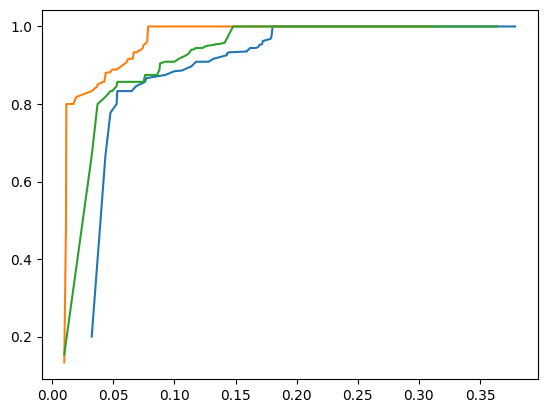


******* Running for  medium  groups *************

#########-------For AF-------#########
 hello :  70 70
size of groups :  70

AF method: mean precision:  0.9404555383327214
AF method: mean recall:  0.14467240203302353

#########-------For BF-------#########

BF method: mean precision:  0.9302789197816287
BF method: mean recall:  0.08311267397545054
size of groups :  70

#########-------For WBF-------#########

WBF method: mean precision:  0.9474800394810647
WBF method: mean recall:  0.12590900522633292
size of groups :  70


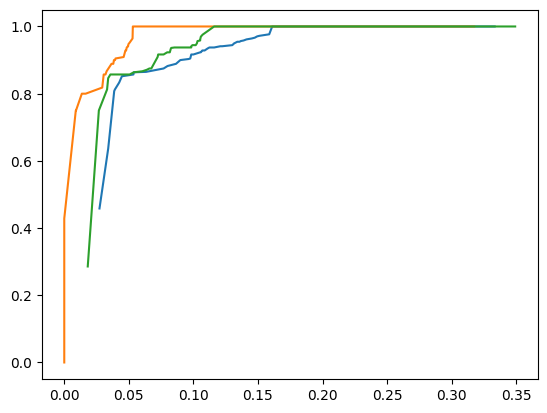


******* Running for  large  groups *************

#########-------For AF-------#########
 hello :  70 70
size of groups :  70

AF method: mean precision:  0.9043668113548278
AF method: mean recall:  0.09191013771067995

#########-------For BF-------#########

BF method: mean precision:  0.8909835333748377
BF method: mean recall:  0.05434655042873583
size of groups :  70

#########-------For WBF-------#########

WBF method: mean precision:  0.9029634237019339
WBF method: mean recall:  0.08302290174122472
size of groups :  70


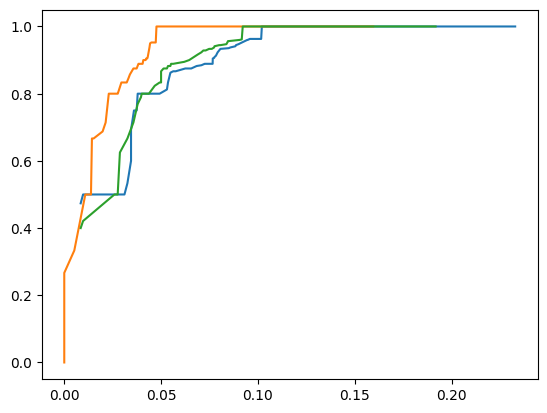

In [ ]:
for idx, groups in enumerate(group_set):
    if groups is []:
        continue
    print ('\n******* Running for ', group_type[idx], ' groups *************')
    # h=np.std(list(filter(lambda a: a != 0, [1,2,3,4,5] )));

    gr.add_groups(groups)
    gr.run_all_methods(groups)
    gr.remove_groups(groups)